<a href="https://colab.research.google.com/github/PeiLi-Sandman/localization-for-smartphone-trajectory-data/blob/master/movement_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# from map_plot import *
# from generate_data import *
# from generate_data_lstm import *
# from filter_function import *
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten, MaxPooling1D, BatchNormalization, CuDNNLSTM, Activation, GRU
from keras import optimizers
from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
rotation = ['rotation_0', 'rotation_1', 'rotation_2', 'rotation_3',
            'rotation_4', 'rotation_5', 'rotation_6', 'rotation_7',
            'rotation_8', 'bearing', 'magneticde']
path = r'/content/drive/My Drive/label'
#path = r'C:\Users\pe601428\OneDrive - Knights - University of Central Florida\TRB\smartphone\label'
#time_lag is used for exp moving average
time_lag = 40
#step is for time slice number of lstm
step = -40
feature_number = 4

In [0]:
# reoriented, raw = get_data(path)

In [0]:
# test = reoriented.groupby(by='movement').mean()
# test = test.reset_index()
# for y in ['ax','ay','az','gyx','gyy','gyz','speed']:
#     plt.figure()
#     sns.barplot(x='movement', y=y, data = test)

In [0]:
def ExpMovingAverage(values, window):
    import numpy as np

    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a


def get_data_lstm(original_path, feature_number, time_lag=50, step=-10):

    import os
    import pandas as pd
    import numpy as np
    from math import sin, cos

    feature = np.empty((0, -(step*feature_number)))
    label = np.empty((0, 1))

    for file in os.listdir(original_path):

        if file.endswith('.csv'):
            
            path = os.path.join(original_path, file)
            
            df = pd.read_csv(path)
            df['Created'] = pd.to_datetime(df['Created'])
            df = df.sort_values(by='Created')
            df = df.drop_duplicates(subset=['lat', 'lon'])
            
            df = df.reset_index()
            df['time'] = df['Created'].dt.ceil('s')
            
            df = df.loc[:, ['time', 'accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz',
                            'magnetx', 'magnety', 'magnetz', 'lon', 'lat', 'error', 'speed',
                            'direction', 'bearing', 'magneticde', 'rotation_0', 'rotation_1', 
                            'rotation_2', 'rotation_3', 'rotation_4','rotation_5', 'rotation_6', 
                            'rotation_7', 'rotation_8', 'movement']]
            rotation = ['rotation_0', 'rotation_1', 'rotation_2', 'rotation_3',
            'rotation_4', 'rotation_5', 'rotation_6', 'rotation_7',
            'rotation_8', 'bearing', 'magneticde']


            # df[rotation] = df[rotation].apply(lambda x: ExpMovingAverage(x, time_lag))
            # df = df[time_lag-1:]
            # df = df.reset_index(drop=True)

            df['geometryAx'] =df['rotation_0'] * df['accx'] + df['rotation_1']*df['accy'] + df['rotation_2']*df['accz']
            df['geometryAy'] =df['rotation_3'] * df['accx'] + df['rotation_4']*df['accy'] + df['rotation_5']*df['accz']
            df['geometryAz'] =df['rotation_6'] * df['accx'] + df['rotation_7']*df['accy'] + df['rotation_8']*df['accz']

            df['geometrygyrox'] =df['rotation_0'] * df['gyrox'] + df['rotation_1']*df['gyroy'] + df['rotation_2']*df['gyroz']
            df['geometrygyroy'] =df['rotation_3'] * df['gyrox'] + df['rotation_4']*df['gyroy'] + df['rotation_5']*df['gyroz']
            df['geometrygyroz'] =df['rotation_6'] * df['gyrox'] + df['rotation_7']*df['gyroy'] + df['rotation_8']*df['gyroz']

            df['teta'] = df['bearing'] - df['magneticde']

            df['ax'] = df['geometryAy'] * df['teta'].apply(sin) + df['geometryAx'] * df['teta'].apply(cos)
            df['ay'] = df['geometryAy'] * df['teta'].apply(cos) - df['geometryAx'] * df['teta'].apply(sin)
            df['az'] = df['geometryAz']

            df['gyx'] = df['geometrygyroy'] * df['teta'].apply(sin) + df['geometrygyrox'] * df['teta'].apply(cos)
            df['gyy'] = df['geometrygyroy'] * df['teta'].apply(cos) - df['geometrygyrox'] * df['teta'].apply(sin)
            df['gyz'] = df['geometrygyroz']          
                    
            df2 = df.loc[:, ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz', 'speed', 'movement']]      
            # df1 = df.loc[:, ['ax', 'ay', 'az', 'gyx', 'gyy', 'gyz', 'speed', 'movement']]
            df1 = df.loc[:, ['ax', 'ay', 'gyx', 'gyy', 'gyz', 'speed', 'movement']]
            	
            #features = ['ax', 'gyz', 'speed']
            features = ['ax', 'gyz', 'gyx', 'speed']
            
            df[features] = df[features].apply(lambda x: ExpMovingAverage(x, time_lag))
            df = df[time_lag-1:]
            df = df.reset_index(drop=True)

            X =[]

            for i in range(0, step, -1):
                
                sli = df1.shift(i)[features]
                x_i = sli[features].values
                y = df1.shift(step+1)['movement'].values
                X.append(x_i)
                
            X = np.hstack(X)
            X = X[:(step+1)]
            y = y[:(step+1)]
            y = y.reshape(y.shape[0],1)

            feature = np.append(feature, X, axis = 0)
            label = np.append(label, y, axis = 0)

    return feature, label

In [0]:
feature, label = get_data_lstm(path, time_lag=time_lag, step=step, feature_number=feature_number)

In [0]:
def generate_train_test(data):
    
    X = data.iloc[:,:feature_number].values
    y = data.iloc[:,-1].values
    y = y.astype(int)
    y = np_utils.to_categorical(y)
    return X, y

In [0]:
# X, y = generate_train_test(reoriented)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# smote_tomek = SMOTETomek(random_state=0)
# X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
# y_test = np.argmax(y_test, axis=1)

# rf = RandomForestClassifier(n_estimators=30, 
#                             max_depth=15, 
#                             max_features='auto', 
#                             class_weight='balanced',
#                             criterion='gini')
# rf = OneVsRestClassifier(rf).fit(X_train, y_train)

# pred = rf.predict_proba(X_test)
# y_pred_value = np.argmax(pred, axis=1)

# print('-----result of random forest-----')
# print(classification_report(y_test, y_pred_value))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(feature, label,
                                                    stratify=label, 
                                                    test_size=0.25,
                                                   random_state=1)

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
# Over Sampling

from imblearn.over_sampling import SMOTE

# smote = SMOTE('minority')
# X_train, y_train = smote.fit_sample(X_train, y_train)

smote_tomek = SMOTETomek(random_state=0)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

# smote_eenn = SMOTEENN(random_state=0)
# X_train, y_train = smote_eenn.fit_resample(X_train, y_train)

In [13]:
y_label = np.argmax(y_train, axis=1)

y = np.bincount(y_label)
ii = np.nonzero(y)[0]

np.vstack((ii,y[ii])).T

array([[   0, 5003],
       [   1, 5003],
       [   2, 5003],
       [   3, 5003]])

In [0]:
# Reshape All The Data
X_train = X_train.reshape(X_train.shape[0],-step,feature_number)
# y_train = y_train.reshape(y_train.shape[0],)
X_test = X_test.reshape(X_test.shape[0],-step,feature_number)
# y_test = y_test.reshape(y_test.shape[0],)

In [0]:
#Create A LSTM Model
adam = optimizers.Adam(lr=0.01)

model = Sequential()
model.add(CuDNNLSTM(32, input_shape=(-step, feature_number), return_sequences=True))
model.add(Dropout(0.6))

model.add(CuDNNLSTM(16, input_shape=(-step, feature_number), return_sequences=True))
model.add(Dropout(0.6))

model.add(Conv1D(16, 4, activation='relu', padding='same'))
model.add(Dropout(0.6))

model.add(Flatten())

model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [57]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100)

Train on 20012 samples, validate on 1818 samples
Epoch 1/10
20012/20012 [==============================] - 6s 311us/step - loss: 0.8314 - acc: 0.6499 - val_loss: 0.6276 - val_acc: 0.7552
Epoch 2/10
20012/20012 [==============================] - 5s 227us/step - loss: 0.3382 - acc: 0.8834 - val_loss: 0.3481 - val_acc: 0.8658
Epoch 3/10
20012/20012 [==============================] - 5s 236us/step - loss: 0.2221 - acc: 0.9241 - val_loss: 0.2345 - val_acc: 0.9054
Epoch 4/10
20012/20012 [==============================] - 5s 227us/step - loss: 0.1936 - acc: 0.9365 - val_loss: 0.2498 - val_acc: 0.9081
Epoch 5/10
20012/20012 [==============================] - 5s 232us/step - loss: 0.1708 - acc: 0.9437 - val_loss: 0.2369 - val_acc: 0.9158
Epoch 6/10
20012/20012 [==============================] - 5s 231us/step - loss: 0.1518 - acc: 0.9497 - val_loss: 0.2271 - val_acc: 0.9224
Epoch 7/10
20012/20012 [==============================] - 5s 225us/step - loss: 0.1525 - acc: 0.9517 - val_loss: 0.1932 - v

In [58]:
pred = model.predict_proba(X_test)
y_pred_value = np.argmax(pred, axis=1)
y_test_value = np.argmax(y_test, axis=1)

print('-----result of LSTM-----')
print(classification_report(y_test_value, y_pred_value))

-----result of LSTM-----
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1667
           1       0.63      0.97      0.76        64
           2       0.53      0.97      0.68        70
           3       0.77      1.00      0.87        17

    accuracy                           0.94      1818
   macro avg       0.73      0.97      0.82      1818
weighted avg       0.96      0.94      0.95      1818



In [55]:
pred = model.predict_proba(X_test)
y_pred_value = np.argmax(pred, axis=1)
y_test_value = np.argmax(y_test, axis=1)

print('-----result of LSTM-----')
print(classification_report(y_test_value, y_pred_value))

-----result of LSTM-----
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1667
           1       0.71      0.97      0.82        64
           2       0.70      0.94      0.80        70
           3       0.74      1.00      0.85        17

    accuracy                           0.96      1818
   macro avg       0.79      0.97      0.86      1818
weighted avg       0.97      0.96      0.97      1818



In [27]:
pred = model.predict_proba(X_test)
y_pred_value = np.argmax(pred, axis=1)
y_test_value = np.argmax(y_test, axis=1)

print('-----result of LSTM-----')
print(classification_report(y_test_value, y_pred_value))

-----result of LSTM-----
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1667
           1       0.78      0.94      0.85        64
           2       0.60      0.91      0.72        70
           3       0.71      1.00      0.83        17

    accuracy                           0.96      1818
   macro avg       0.77      0.95      0.84      1818
weighted avg       0.97      0.96      0.96      1818



In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 40, 32)            4864      
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 40, 16)            3200      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 8)             520       
_________________________________________________________________
dropout_11 (Dropout)         (None, 37, 8)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 296)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1188      
Total para

In [0]:
layer = model.get_layer('dense_6')
layer_output = layer.output

In [48]:
from keras import models

activation_model = models.Model(input=model.input, outputs=[layer_output])
activations = activation_model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("cu...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

In [0]:
class_names = ['No Turning','Left Turn','Right Turn','U-turn']


def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [51]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 11.894596576690674 seconds


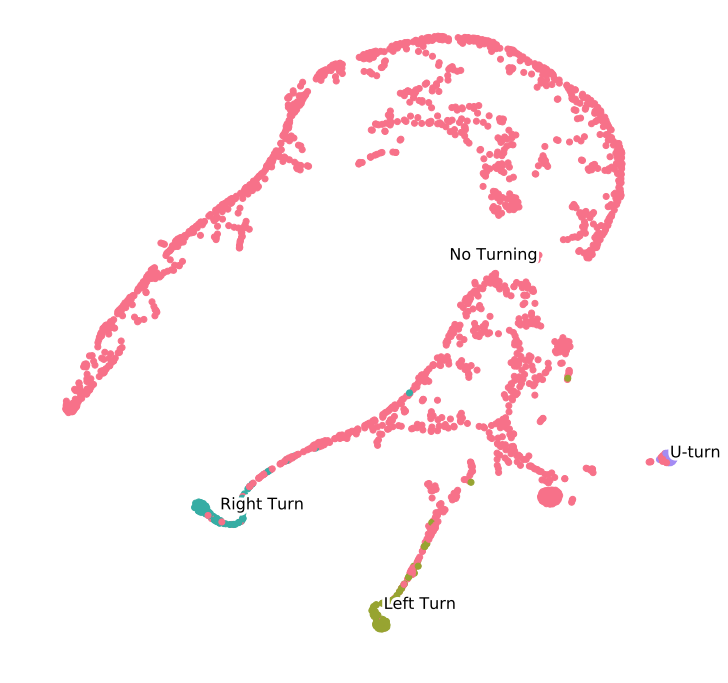

In [52]:
data_scatter(fashion_tsne, y_test_value)

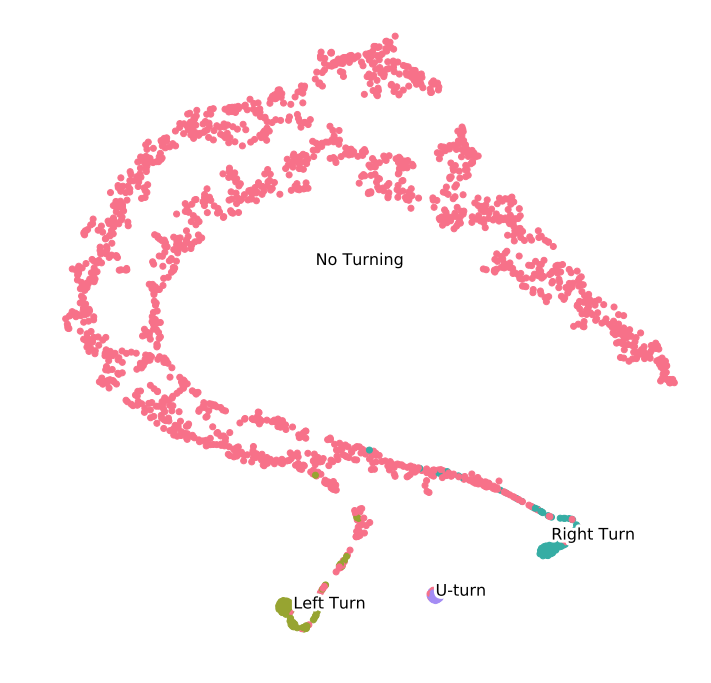

In [39]:
data_scatter(fashion_tsne, y_test_value)

In [0]:
y_score = model.predict_proba(X_test)

In [19]:
print(__doc__)

n_classes = 4

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment


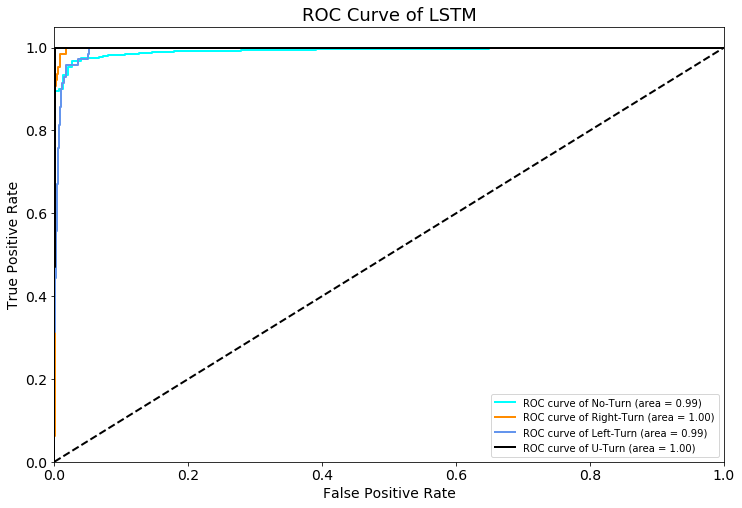

In [20]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'black'])

names = ['No-Turn', 'Right-Turn', 'Left-Turn', 'U-Turn']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ROC Curve of LSTM', fontsize=18)
plt.legend(loc="lower right")
# plt.savefig(r'G:\Project\Smart Phone\Report\roc_auc.png', 
#              bbox_inches = 'tight',
#              dpi=300)
plt.show()